# Lag Operator

먼저 Autocorrelation을 하기전에 Lag Operator에 대해서 알아야 합니다.<br>
Lag Operator $ L $ 또는 Backshift $ B $ 로 표현을 하며 시계열상의 과거의 데이터를 설명할때 사용합니다.

$$ \begin{align} 
Ly_t &= y_{t-1} \\
y_t &= Ly_{t+1} \\
\end{align} $$

이때 Lag Operator $ L $ 은 여러가지 정수값으로 제곱이 될 수 있습니다.

$$ \begin{align} 
L^ky_t &= y_{t-k} \\
L^{-1}y_t &= y_{t+1} \\
L^2y_t &= y_{t-2} \\
\end{align}$$

### Lag Polynomials

$ a(L) $ 를 lag polynomials 로 정의한다면 다음과 같습니다.

$$ a(L) = a_0 + a_1L + ... + a_pL^p $$

위의 공식은 operator로서 사용이 될 수 있습니다.

$$ a(L)x_t = a_0x_t + a_1x_{t-1} + .. + a_p x_{t-p} $$

lag polynomials는 더하거나 곱하는 연산을 할 수도 있습니다. <br>
예를 들어서 만약 $ a(L) = (1-aL) $ 이고 $ b(L) = (1-bL) $ 이라면 

$$ \begin{align} 
a(L)b(L)x_t &=  (1-aL)(1-bL)x_t \\
  &= (1-aL)(x_t - bx_{t-1}) \\
  &= x_t - bx_{t-1} - aL(x_t - bx_{t-1}) \\
  &= x_t - bx_{t-1} - a(x_{t-1} - bx_{t-2}) \\
  &= x_t - bx_{t-1} - ax_{t-1} + abx_{t-2} \\
  &= x_t -(a+b)x_{t-1} + abx_{t-2} \\
  &= \left( 1 - (a+b)L + abL^2 \right) x_t
\end{align} $$

### Invert 

lag polymials 는 inverted될 수 있습니다. 

$$ (1-pL)(1-pL)^{-1} = \frac{(1-pL)}{(1-pL)} = 1 $$


### Difference Operator 

Time series 분석에서 first difference operator $ \Delta $ 는 lag polynomial의 특별한 케이스입니다.

$$ \begin{align} 
\Delta X_t &= X_t - X_{t-1} \\
\Delta X_t &= (1 - L)X_t \\
\end{align} $$

유사하게 second difference operator는 다음과 같습니다.

$$ \begin{align} 
\Delta(\Delta X_t) &= \Delta X_t - \Delta X_{t-1} \\
  \Delta^2 X_t &= (1 - L) \Delta X_t \\
  \Delta^2 X_t &= (1-L)(1-L) X_t \\
  \Delta^2 X_t &= (1-L)^2 X_t
\end{align} $$

위의 공식은 다음과 같이 일반화 될 수 있습니다.

$$ \Delta^i X_i = (1-L)^i X_t $$

Seconds Difference의 예제는 다음과 같습니다.

| Original Sequence | 0  |    | 1  |    | 4  |    | 9  |    | 16 |    | 25 |    | 36 |
|:------------------|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| First Difference  |    | 1  |    | 3  |    | 5  |    | 7  |    | 9  |    | 11 |    |
| Second Difference |    |    | 2  |    | 2  |    | 2  |    | 2  |    | 2  |    |&nbsp;|


# Autocorrelation Checking

Autoregression은 이전의 time-steps의 observations을 통해 다음 step의 값을 예측하는데 사용될 수 있다는 가정을 갖고 있습니다.<br>
variables관의 관계를 correlation이라고 하며, 두 variables이 동시에 증가하거나 감소하면 **positive correlation**이라고 하며, 서로 반대방향으로 움직인다면 (하나는 증가하고, 하나는 감소하는 상황.) **negative correlation**이라고 합니다.

output variable (예측값) 그리고 이전 time-steps의 값(lagged variables)들의 correlation을 구함으로서 통계적 측정을 할 수 있습니다.<br>
correlation을 통해서 얼마만큼의 lag variables을 사용해야될지 알 수 있으며, 그래프가 predictable한지 안 한지도 알 수 있습니다.

> Autocorrelation에서 auto가 붙는 이유는 위에서 설명했듯이, 자기자신(auto or self)의 데이터를 사용하여 자기 자신의 데이터를 예측하기 때문에 이렇게 이름이 지어졌습니다.





## Import

In [1]:
%pylab inline
import math
import pandas as pd

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data 

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0


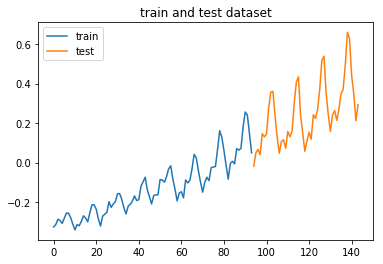

In [2]:
TEST_SIZE = 50

def get_data():
    dataframe = pd.read_csv('/dataset/time-series/international-airline-passengers/international-airline-passengers.csv', 
                       names=[ 'passenger'], index_col=0,
                       skiprows=1)
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe = dataframe.astype('float64')


    scaler = MinMaxScaler()
    data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

    # Mean Adjusted Time Series
    mu = np.mean(data)
    data_adjusted = data - mu

    train, test = data_adjusted[:-TEST_SIZE], data_adjusted[-TEST_SIZE:]
    
    return dataframe, data_adjusted, train, test

dataframe, data_adjusted, train, test = get_data()

print(dataframe.head())
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

In [3]:
LAG = 12
def to_timeseries(data, lag):
    data = data.reshape(-1)
    N = len(data[LAG:])
    ts = list()
    
    for i in range(N):
        ts.append(data[i:i+LAG].tolist())
    ts = np.array(ts)
    return ts
    
ts_data = to_timeseries(data_adjusted, lag=LAG)
ts_train, ts_test = ts_data[:-TEST_SIZE], ts_data[-TEST_SIZE:]

print('ts_train:', ts_train.shape)
print('ts_test :', ts_test.shape)

ts_train: (82, 12)
ts_test : (50, 12)


## Lag Plot 

빠르게 correlation이 존재하는지 확인하는 방법은 step t 와 t-1 을 scatter plot으로 그래서 확인하는 방법입니다.<br>
집접 데이터를 가공해서 만들수도 있지만, Pandas에서는 lag_plot이라는 함수를 통해서 쉽게 lag plot을 그려볼 수 있습니다.


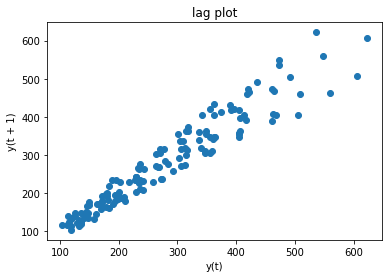

In [4]:
lag_plot(dataframe, lag=1)
title('lag plot')

step t 와 step t-1 의 관계가 전혀 없는 random한 상황속에서는 다음과 같이 그래프가 그려집니다.

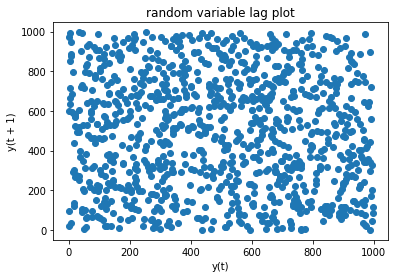

In [6]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
lag_plot(series)
title('random variable lag plot')

## Pearson Correlation Coefficient

t-1 과 t의 상관관계를 pearson correlation으로 구할수 있습니다. <br>

* negative correlated: -1 
* positive correlated: 1
* correlation: 0.5보다 크거나, -0.5보다 작을시 높은 correlation

아래의 예제에서는 0.77487의 correlation값을 보이는데 positive correlated이며 correlation이 높다고 할 수 있습니다.

In [7]:
data2 = pd.concat([dataframe.shift(2), dataframe.shift(1), dataframe], axis=1)
data2.columns = ['t-2', 't-1', 't']
data2.corr()

,t-2,t-1,t
t-2,1.000000,0.960249,0.895675
t-1,0.960249,1.000000,0.960195
t,0.895675,0.960195,1.000000


## Autocorrelation Plot

각각의 lag variable에 대한 correlation을 plotting할 수 도 있지만, Pandas에서 이미 지원해주고 있습니다.

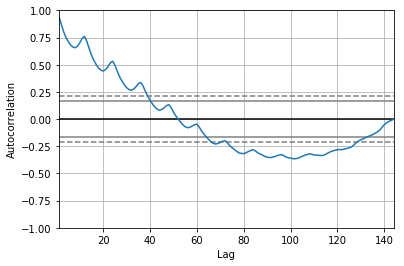

In [8]:
autocorrelation_plot(data)

statsmodel 라이브러리에서 제공하는 plot_acf를 사용할수도 있습니다.

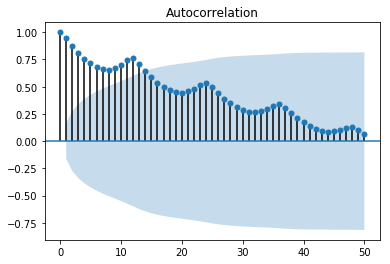

In [9]:
plot_acf(data, lags=50)
print(end='')

Random variable의 경우에는 다음과 같이 전혀 맞지 않게 나옵니다.

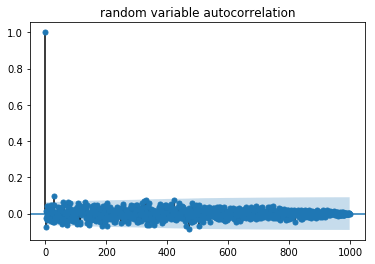

In [10]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
plot_acf(series, title='random variable autocorrelation')
print()